# Plan of attacks
1. test ELU<br>


In [1]:
#for i in *.jpeg; do newname="$(echo $i|cut -d. -f1)";mv $i $newname;done

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import numpy as np
import itertools as it
from skimage import io, transform
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
pwd

'/home/brian/Desktop/Walker_droplets'

In [4]:

PATH         = './data_reduced'
EPOCH        = 80
BATCH_SIZE   = 1 #5
LR           = 0.00001
WORKERS      = 3
WD           = 1e-8
MIN          = 6.0e-10
MAX          = 1.0-6.0e-10
L            = 200
ALPHA        = 0.9
FO           = 24
FI           = 12
MASK         = np.loadtxt('./img_mask')

In [5]:
class WDD(Dataset):
    def __init__(self, root_dir, mask, transform=None):
        self.root_dir = root_dir
        self.mask = mask.type(torch.FloatTensor)
        self.transform = transform  
        self.n_images = len(os.listdir(root_dir))
    def __len__(self):
            return self.n_images    
    def __getitem__(self, location):
        img_name = PATH + '/' +str(location) 
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
        image.mul_(self.mask)
        return image

tense        = transforms.ToTensor()
pil          = transforms.ToPILImage()
resize       = transforms.Resize((L,L))
grayscale    = transforms.Grayscale()
composed     = transforms.Compose([pil, resize, grayscale, tense])
        
d_set        = WDD(PATH, tense(MASK), composed)
print(f'Number of images in the dataset is {len(d_set)}')

cae_loader = DataLoader(dataset=d_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=WORKERS)

Number of images in the dataset is 549


## Convolutional Autoencoder

In [6]:
# Note: (N,Cin,Hin,Win)
# N: batch size of input. So 100 RGB 28X28 images is (100,3,100,100) 

class Enc(nn.Module):
    def __init__(self):
        super(Enc, self).__init__()

        self.E_cnnOuter = nn.Conv2d(in_channels=1,
                                out_channels=FO,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.E_bnOuter = nn.BatchNorm2d(FO)
        self.E_tOuter = nn.ELU(alpha=ALPHA)
        self.E_mpOuter = nn.MaxPool2d(2, 
                                    stride=2,
                                    padding=0,
                                    return_indices=True)
        
        self.E_cnnInner = nn.Conv2d(FO, FI,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1)
        self.E_bnInner = nn.BatchNorm2d(FI)
        self.E_tInner = nn.ELU(alpha=ALPHA)
        self.E_mpInner = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0,
                                    return_indices=True)
    def forward(self, input):
        x = self.E_cnnOuter(input)
        x = self.E_tOuter(x)
        x = self.E_bnOuter(x)
        x, o_index = self.E_mpOuter(x)
        
        x = self.E_cnnInner(x)
        x = self.E_tInner(x)
        x = self.E_bnInner(x)
        x, i_index = self.E_mpInner(x)
        
        return x, i_index, o_index
        

class Dec(nn.Module):
    def __init__(self):
        super(Dec, self).__init__()
        self.D_mpInner = nn.MaxUnpool2d(kernel_size=2,
                                         stride=2,
                                         padding=0)
        self.D_tInner   = nn.ELU(alpha=ALPHA) 
        self.D_bnInner = nn.BatchNorm2d(FI)
        self.D_cnnInner = nn.ConvTranspose2d(FI, FO,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1)
        self.D_mpOuter = nn.MaxUnpool2d(kernel_size=2,
                                        stride=2,
                                        padding=0)
        self.D_tOuter = nn.ELU(alpha=ALPHA)
        self.D_bnOuter = nn.BatchNorm2d(FO)
        self.D_cnnOuter = nn.ConvTranspose2d(FO, 1,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1)
        self.sig = nn.Sigmoid()
        
    
    def forward(self, input, i_index, o_index):
        x = self.D_mpInner(input, i_index)
        x = self.D_tInner(x)
        x = self.D_bnInner(x)
        x = self.D_cnnInner(x)
        x = self.D_mpOuter(x, o_index)
        x = self.D_tOuter(x)
        x = self.D_bnOuter(x)
        x = self.D_cnnOuter(x)
        
        x = self.sig(x)
        return x
    
enc = Enc().cuda()
dec = Dec().cuda()

  0%|          | 0/80 [00:00<?, ?it/s]

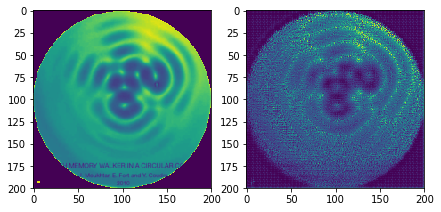

  1%|▏         | 1/80 [00:04<05:31,  4.20s/it]

Loss 0.00


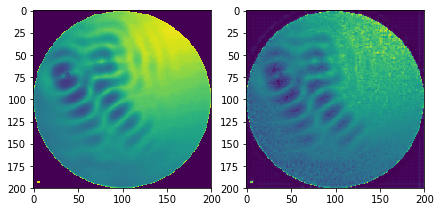

  2%|▎         | 2/80 [00:08<05:22,  4.13s/it]

Loss 0.00


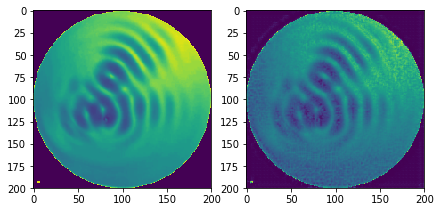

  4%|▍         | 3/80 [00:12<05:17,  4.12s/it]

Loss 0.00


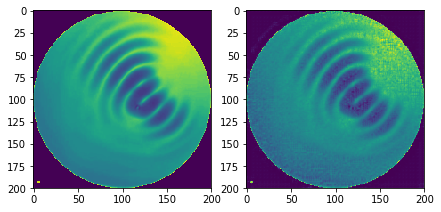

  5%|▌         | 4/80 [00:16<05:13,  4.12s/it]

Loss 0.00


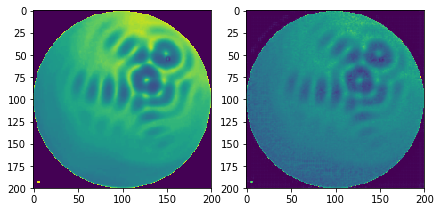

  6%|▋         | 5/80 [00:20<05:13,  4.18s/it]

Loss 0.00


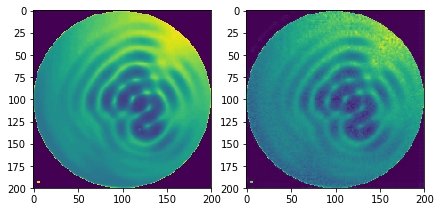

  8%|▊         | 6/80 [00:24<05:10,  4.20s/it]

Loss 0.00


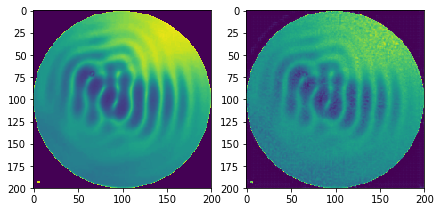

  9%|▉         | 7/80 [00:29<05:03,  4.16s/it]

Loss 0.00


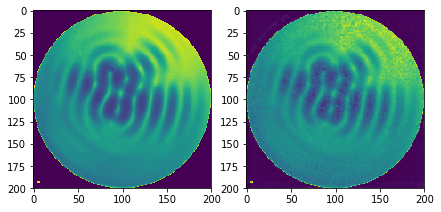

 10%|█         | 8/80 [00:33<04:55,  4.10s/it]

Loss 0.00


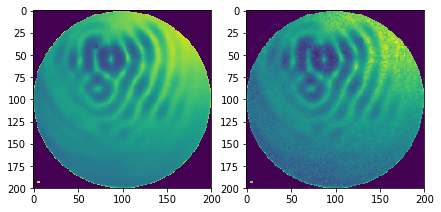

 11%|█▏        | 9/80 [00:37<04:52,  4.12s/it]

Loss 0.00


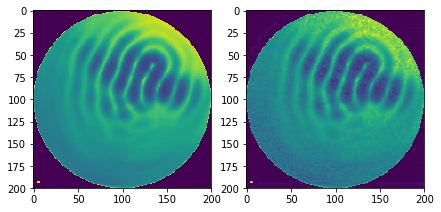

 12%|█▎        | 10/80 [00:41<04:46,  4.10s/it]

Loss 0.00


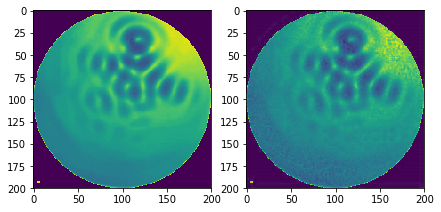

 14%|█▍        | 11/80 [00:45<04:45,  4.13s/it]

Loss 0.00


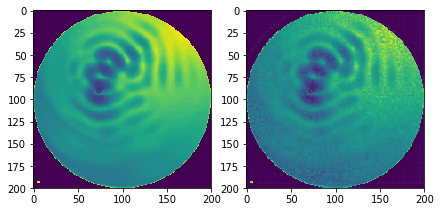

 15%|█▌        | 12/80 [00:49<04:37,  4.08s/it]

Loss 0.00


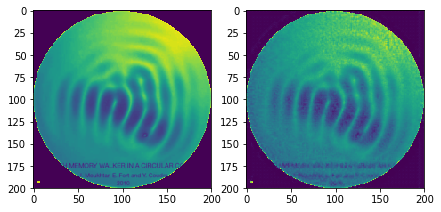

 16%|█▋        | 13/80 [00:53<04:31,  4.05s/it]

Loss 0.00


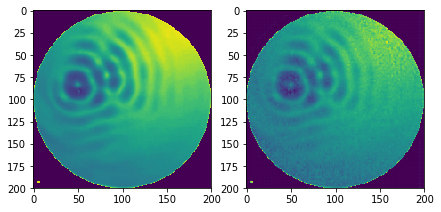

 18%|█▊        | 14/80 [00:57<04:25,  4.03s/it]

Loss 0.00


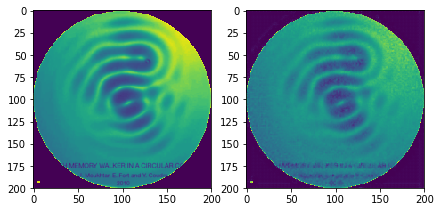

 19%|█▉        | 15/80 [01:01<04:20,  4.01s/it]

Loss 0.00


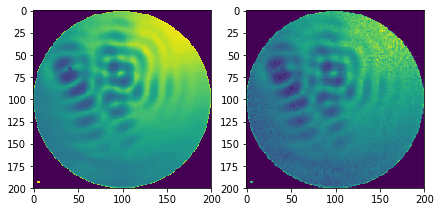

 20%|██        | 16/80 [01:05<04:21,  4.09s/it]

Loss 0.00


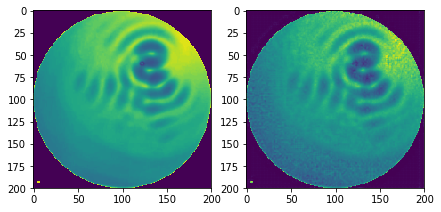

 21%|██▏       | 17/80 [01:09<04:19,  4.12s/it]

Loss 0.00


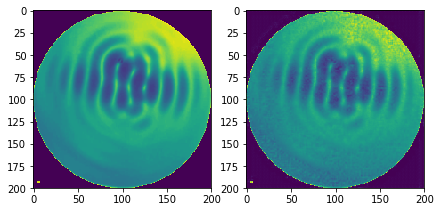

 22%|██▎       | 18/80 [01:13<04:16,  4.13s/it]

Loss 0.00


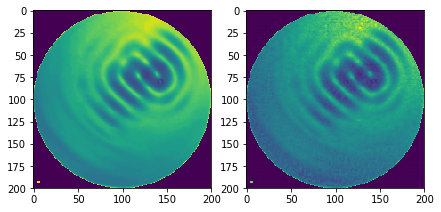

 24%|██▍       | 19/80 [01:18<04:11,  4.13s/it]

Loss 0.00


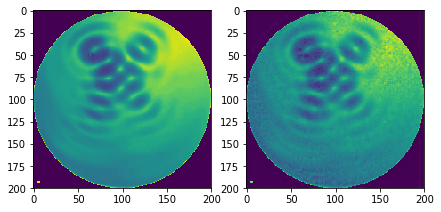

 25%|██▌       | 20/80 [01:22<04:05,  4.09s/it]

Loss 0.00


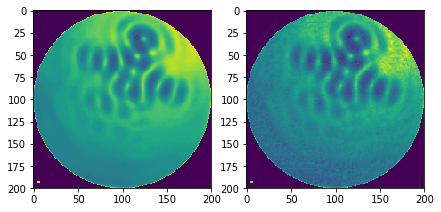

 26%|██▋       | 21/80 [01:26<03:59,  4.07s/it]

Loss 0.00


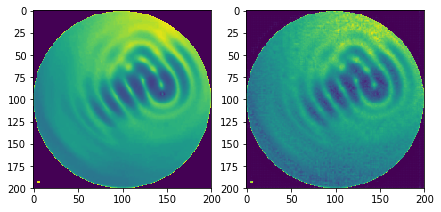

 28%|██▊       | 22/80 [01:30<04:00,  4.15s/it]

Loss 0.00


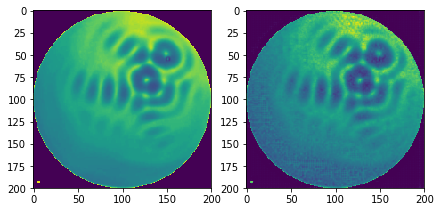

 29%|██▉       | 23/80 [01:34<03:54,  4.12s/it]

Loss 0.00


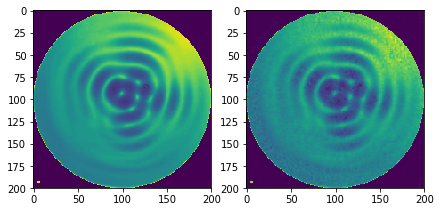

 30%|███       | 24/80 [01:38<03:50,  4.11s/it]

Loss 0.00


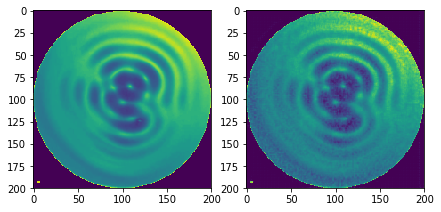

 31%|███▏      | 25/80 [01:42<03:45,  4.10s/it]

Loss 0.00


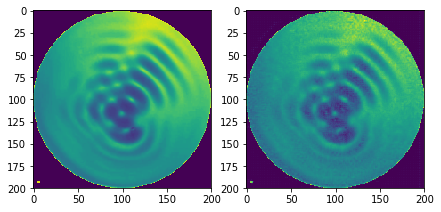

 32%|███▎      | 26/80 [01:47<03:47,  4.22s/it]

Loss 0.00


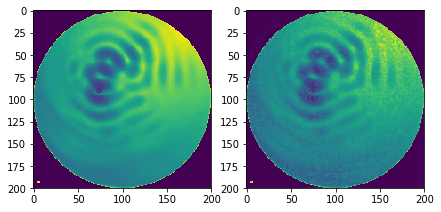

 34%|███▍      | 27/80 [01:51<03:44,  4.24s/it]

Loss 0.00


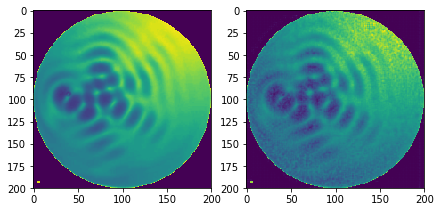

 35%|███▌      | 28/80 [01:55<03:36,  4.16s/it]

Loss 0.00


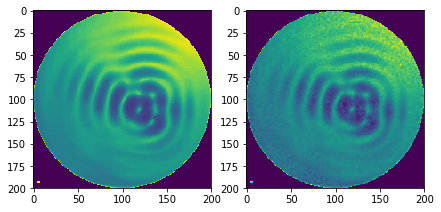

 36%|███▋      | 29/80 [01:59<03:33,  4.18s/it]

Loss 0.00


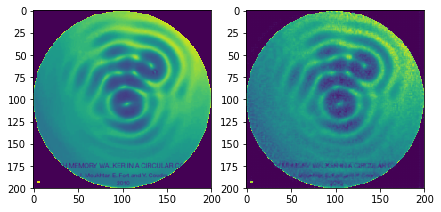

 38%|███▊      | 30/80 [02:03<03:26,  4.13s/it]

Loss 0.00


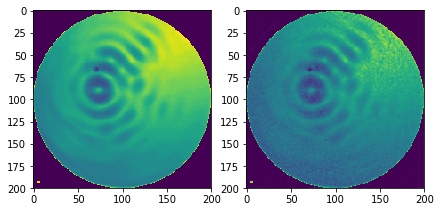

 39%|███▉      | 31/80 [02:07<03:20,  4.09s/it]

Loss 0.00


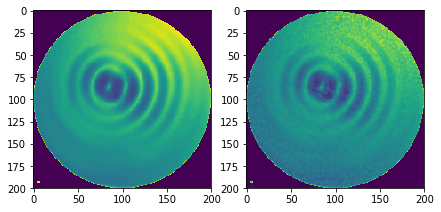

 40%|████      | 32/80 [02:11<03:15,  4.07s/it]

Loss 0.00


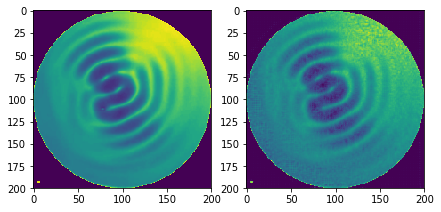

 41%|████▏     | 33/80 [02:15<03:12,  4.10s/it]

Loss 0.00


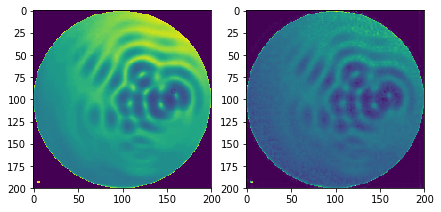

 42%|████▎     | 34/80 [02:19<03:09,  4.12s/it]

Loss 0.00


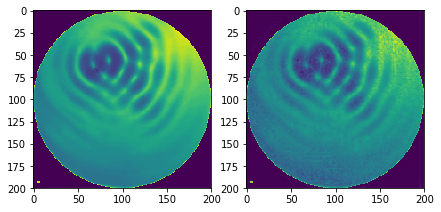

 44%|████▍     | 35/80 [02:24<03:04,  4.09s/it]

Loss 0.00


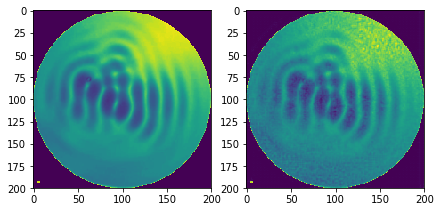

 45%|████▌     | 36/80 [02:27<02:58,  4.06s/it]

Loss 0.00


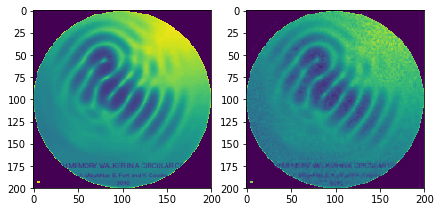

 46%|████▋     | 37/80 [02:32<02:55,  4.08s/it]

Loss 0.00


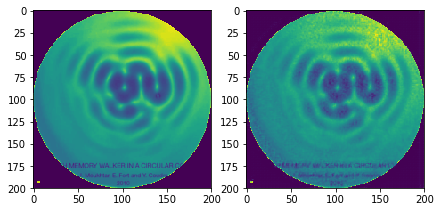

 48%|████▊     | 38/80 [02:36<02:50,  4.06s/it]

Loss 0.00


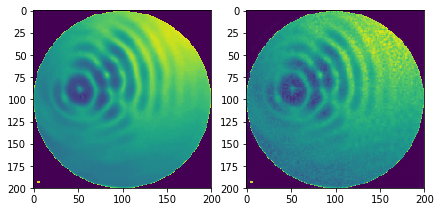

 49%|████▉     | 39/80 [02:40<02:45,  4.04s/it]

Loss 0.00


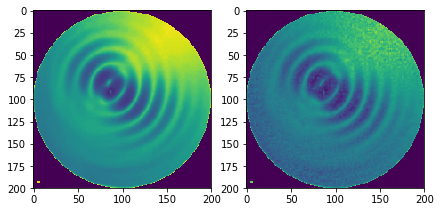

 50%|█████     | 40/80 [02:44<02:40,  4.02s/it]

Loss 0.00


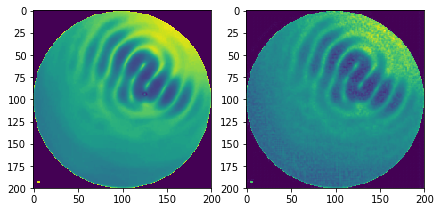

 51%|█████▏    | 41/80 [02:48<02:36,  4.01s/it]

Loss 0.00


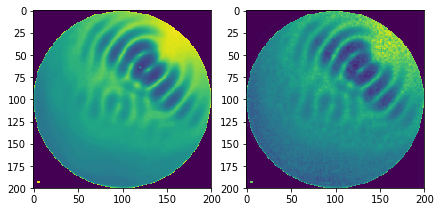

 52%|█████▎    | 42/80 [02:52<02:32,  4.02s/it]

Loss 0.00


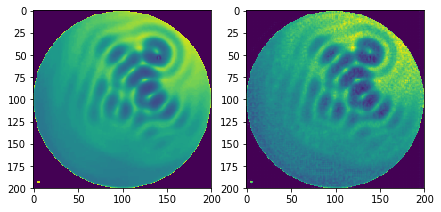

 54%|█████▍    | 43/80 [02:56<02:28,  4.00s/it]

Loss 0.00


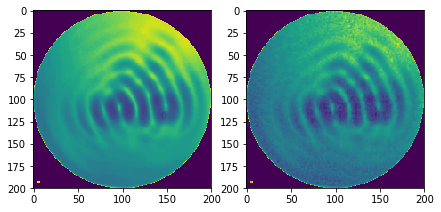

 55%|█████▌    | 44/80 [03:00<02:25,  4.05s/it]

Loss 0.00


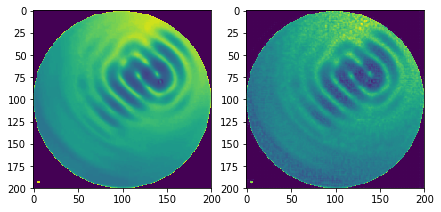

 56%|█████▋    | 45/80 [03:04<02:21,  4.04s/it]

Loss 0.00


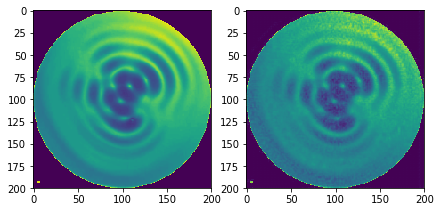

 57%|█████▊    | 46/80 [03:08<02:17,  4.03s/it]

Loss 0.00


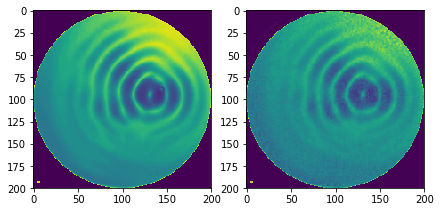

 59%|█████▉    | 47/80 [03:12<02:13,  4.03s/it]

Loss 0.00


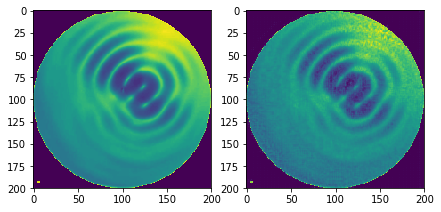

 60%|██████    | 48/80 [03:16<02:08,  4.02s/it]

Loss 0.00


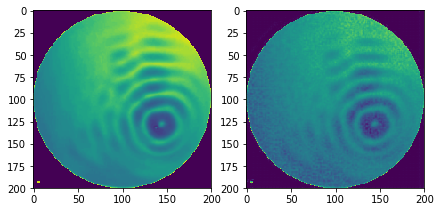

 61%|██████▏   | 49/80 [03:20<02:04,  4.02s/it]

Loss 0.00


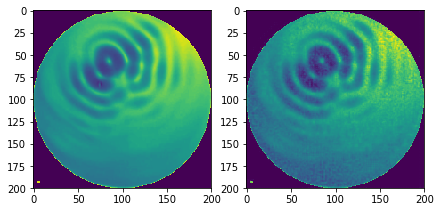

 62%|██████▎   | 50/80 [03:24<02:00,  4.01s/it]

Loss 0.00


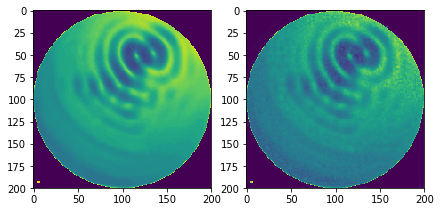

 64%|██████▍   | 51/80 [03:28<01:56,  4.01s/it]

Loss 0.00


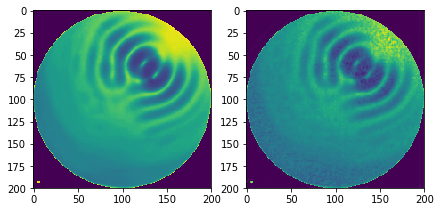

 65%|██████▌   | 52/80 [03:32<01:54,  4.09s/it]

Loss 0.00


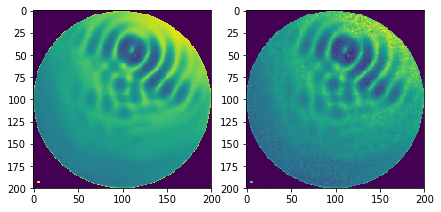

 66%|██████▋   | 53/80 [03:36<01:51,  4.15s/it]

Loss 0.00


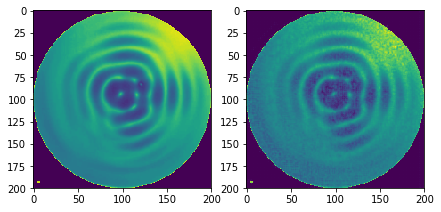

 68%|██████▊   | 54/80 [03:41<01:48,  4.17s/it]

Loss 0.00


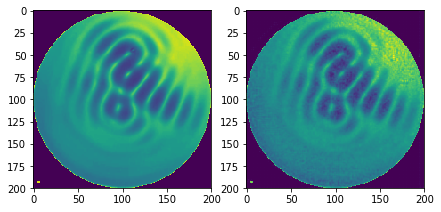

 69%|██████▉   | 55/80 [03:45<01:46,  4.24s/it]

Loss 0.00


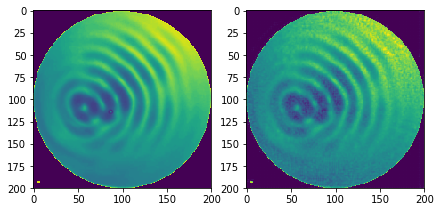

 70%|███████   | 56/80 [03:49<01:42,  4.25s/it]

Loss 0.00


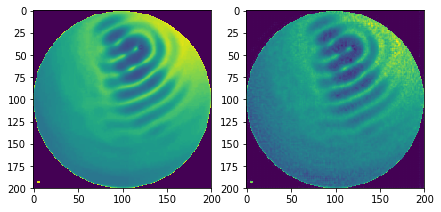

 71%|███████▏  | 57/80 [03:53<01:36,  4.19s/it]

Loss 0.00


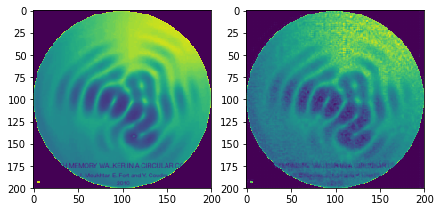

 72%|███████▎  | 58/80 [03:57<01:31,  4.15s/it]

Loss 0.00


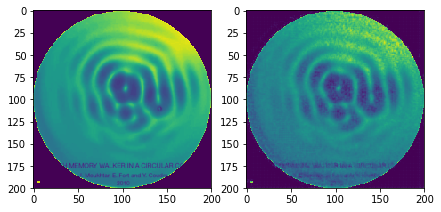

 74%|███████▍  | 59/80 [04:02<01:27,  4.17s/it]

Loss 0.00


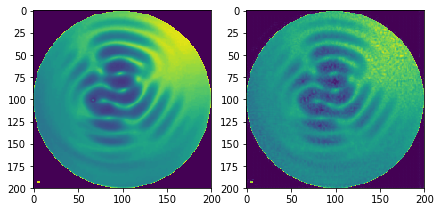

 75%|███████▌  | 60/80 [04:06<01:22,  4.13s/it]

Loss 0.00


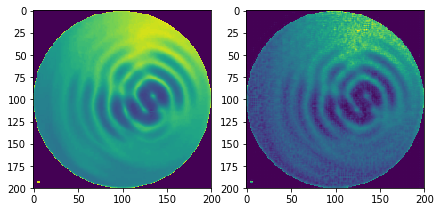

 76%|███████▋  | 61/80 [04:10<01:18,  4.14s/it]

Loss 0.00


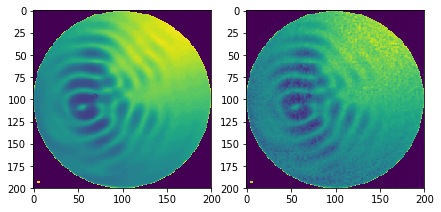

 78%|███████▊  | 62/80 [04:14<01:13,  4.08s/it]

Loss 0.00


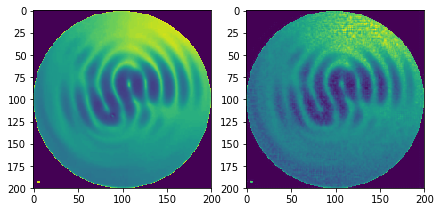

 79%|███████▉  | 63/80 [04:18<01:09,  4.07s/it]

Loss 0.00


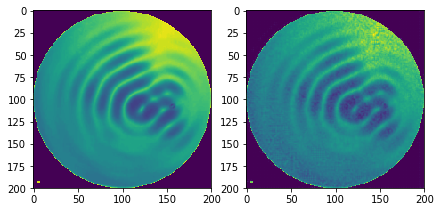

 80%|████████  | 64/80 [04:22<01:04,  4.04s/it]

Loss 0.00


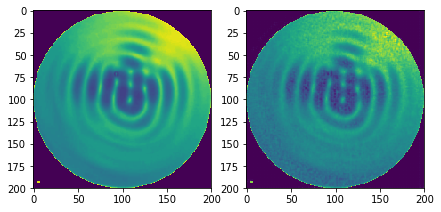

 81%|████████▏ | 65/80 [04:26<01:00,  4.02s/it]

Loss 0.00


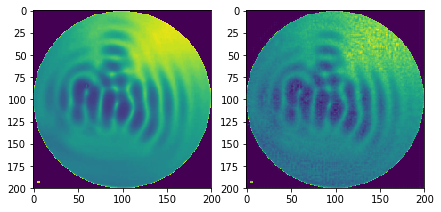

 82%|████████▎ | 66/80 [04:30<00:56,  4.05s/it]

Loss 0.00


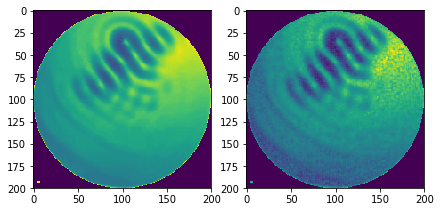

 84%|████████▍ | 67/80 [04:34<00:52,  4.02s/it]

Loss 0.00


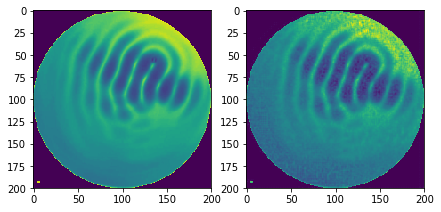

 85%|████████▌ | 68/80 [04:38<00:48,  4.01s/it]

Loss 0.00


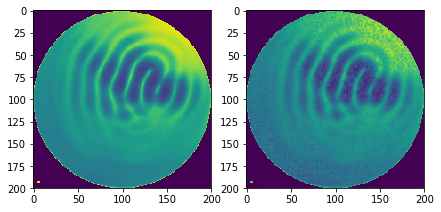

 86%|████████▋ | 69/80 [04:42<00:44,  4.00s/it]

Loss 0.00


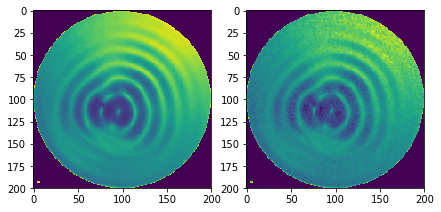

 88%|████████▊ | 70/80 [04:46<00:39,  3.99s/it]

Loss 0.00


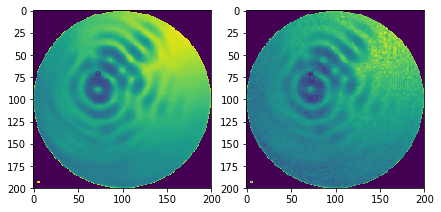

 89%|████████▉ | 71/80 [04:50<00:35,  3.99s/it]

Loss 0.00


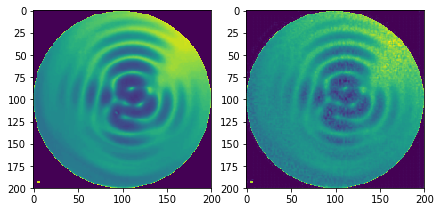

 90%|█████████ | 72/80 [04:54<00:31,  3.98s/it]

Loss 0.00


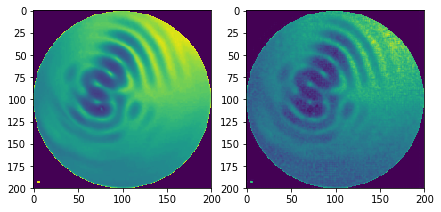

 91%|█████████▏| 73/80 [04:58<00:27,  3.98s/it]

Loss 0.00


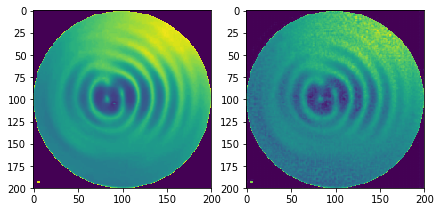

 92%|█████████▎| 74/80 [05:02<00:23,  3.98s/it]

Loss 0.00


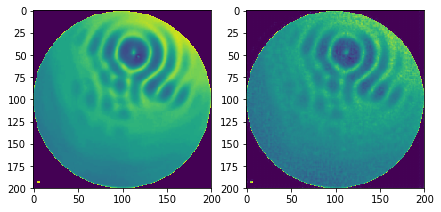

 94%|█████████▍| 75/80 [05:06<00:19,  3.98s/it]

Loss 0.00


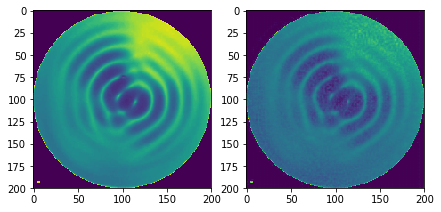

 95%|█████████▌| 76/80 [05:10<00:15,  3.98s/it]

Loss 0.00


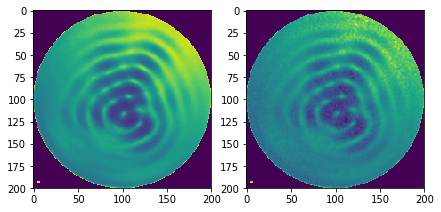

 96%|█████████▋| 77/80 [05:14<00:12,  4.02s/it]

Loss 0.00


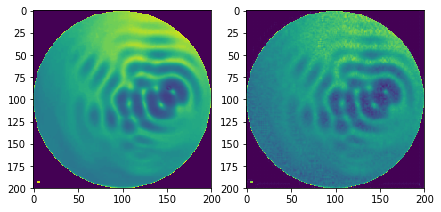

 98%|█████████▊| 78/80 [05:18<00:08,  4.00s/it]

Loss 0.00


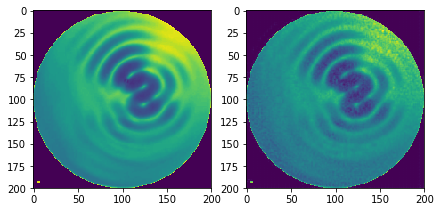

 99%|█████████▉| 79/80 [05:22<00:03,  4.00s/it]

Loss 0.00


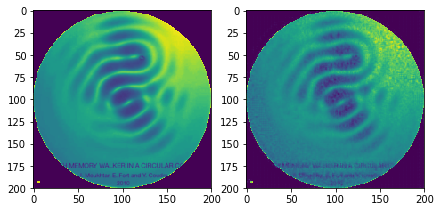

100%|██████████| 80/80 [05:26<00:00,  4.00s/it]

Loss 0.00


In [7]:
chained = it.chain(enc.parameters(), dec.parameters())
optimizer = torch.optim.RMSprop(chained, weight_decay=WD)
loss_fn = nn.MSELoss(reduction='mean')
loss_list = []
plt.ion()
for epoch in tqdm(range(EPOCH)):

    for step, x in enumerate(cae_loader):
        if step==546:break
        b_x = x.cuda()   
        b_y = x.cuda()   
        encoded, inner, outer = enc(b_x)
        #print(encoded.size())
        recon = dec(encoded, inner, outer)
        loss = loss_fn(recon, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            loss_list.append(loss.item())
        
        if(step == 10):
            plt.figure(figsize=(7,7))
            plt.subplot(121)
            orig_img = x.reshape(BATCH_SIZE,L,L)
            plt.imshow(orig_img[0,:,:])
            plt.subplot(122)
            recon_img = recon.detach().cpu().numpy().reshape(BATCH_SIZE,L,L)
            plt.imshow(recon_img[0,:,:])
            plt.show()
        plt.close()
    print(f'Loss {loss.item():.2f}')
plt.ioff()

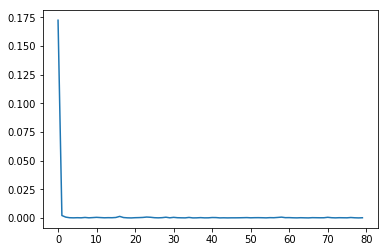

0.0002817929780576378

In [8]:
plt.figure()
plt.plot(loss_list)
plt.show()

loss_list[-1]

In [9]:
#0.027   100 epoch
#0.013

In [12]:
PATH1 = './enc_params'
PATH2 = './dec_params'

torch.save(enc.state_dict(), PATH1)
torch.save(dec.state_dict(), PATH2)

In [11]:
pwd

'/home/brian/Desktop/Walker_droplets'